In [296]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, MDS
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_distances

In [203]:
mut = pd.read_csv('TCGA.HNSC.mutations.txt', sep='\t', header=0, index_col = [0])

In [222]:
clean_mut = mut[mut['Variant_Type'] == 'SNP']
#Sigtool = clean_mut[['Hugo_Symbol', 'Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']]
#Sigtool.to_csv('Sigtool.cvs')
clean_mut = clean_mut[['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2', 'CONTEXT']]


In [205]:

def get_middle(sequence):
    middle_index = len(sequence) // 2
    if len(sequence) % 2 == 0:
        return sequence[middle_index - 1: middle_index + 1]
    else:
        return sequence[middle_index]
# Apply the function to the 'context' column
clean_mut['middle'] = clean_mut['CONTEXT'].apply(get_middle)


In [206]:
def reverse_complement(sequence):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join(complement[base] for base in sequence[::-1])
# Apply the reverse complement function based on the condition
clean_mut['Complement'] = clean_mut['CONTEXT']
clean_mut.loc[clean_mut['middle'].isin(['G', 'A']), 'Complement'] = clean_mut.loc[clean_mut['middle'].isin(['G', 'A']), 'Complement'].apply(reverse_complement)

In [207]:
def find_middle_three(s):
    length = len(s)
    if length >= 3:
        return s[(length//2)-1:(length//2)+2]
    else:
        return s
clean_mut['Tri'] = clean_mut['Complement'].apply(find_middle_three)

In [208]:
clean_mut['Mut'] = (clean_mut['Tri'].str[0] +  "(" + clean_mut['Tri'].str[1] + ">" 
                     + clean_mut['Tumor_Seq_Allele2'].astype(str) + ')' + clean_mut['Tri'].str[2])


In [209]:
clean_mut =  clean_mut[~clean_mut['Mut'].str.contains('(C>C)')]
clean_mut = clean_mut[~clean_mut['Mut'].str.contains('(T>T)')]

/var/folders/x1/0pbqqytx7775hcm5ys9z97y00000gn/T/ipykernel_1132/3941398218.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  clean_mut =  clean_mut[~clean_mut['Mut'].str.contains('(C>C)')]
/var/folders/x1/0pbqqytx7775hcm5ys9z97y00000gn/T/ipykernel_1132/3941398218.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  clean_mut = clean_mut[~clean_mut['Mut'].str.contains('(T>T)')]


In [218]:
clean_mut

,Chromosome,Start_Position,Reference_Allele,Tumor_Seq_Allele2,CONTEXT,middle,Complement,Tri,Mut
patient_id,,,,,,,,,
TCGA-4P-AA8J,10,22830863,G,A,CTCTCGCCCTC,G,GAGGGCGAGAG,GCG,G(C>A)G
TCGA-4P-AA8J,10,33495214,C,T,CATCTCTTCTT,C,CATCTCTTCTT,TCT,T(C>T)T
TCGA-4P-AA8J,10,6257188,C,T,GTGTTCAACGT,C,GTGTTCAACGT,TCA,T(C>T)A
TCGA-4P-AA8J,10,88260246,T,C,TAAAATACAGT,T,TAAAATACAGT,ATA,A(T>C)A
TCGA-4P-AA8J,11,1080567,T,C,TTCGATGGGAA,T,TTCGATGGGAA,ATG,A(T>C)G
...,...,...,...,...,...,...,...,...,...
TCGA-WA-A7H4,8,143381872,C,T,CCTCCCGCAGC,C,CCTCCCGCAGC,CCG,C(C>T)G
TCGA-WA-A7H4,8,59728263,G,A,TTCACGTCAAC,G,GTTGACGTGAA,ACG,A(C>A)G
TCGA-WA-A7H4,8,74235183,G,A,GTATCGGTTCC,G,GGAACCGATAC,CCG,C(C>A)G


In [211]:
mut_matrix = clean_mut[['Mut']]

In [212]:
mut_encoded_matrix = pd.pivot_table(mut_matrix, index='patient_id', columns='Mut', aggfunc='size', fill_value=0)

In [213]:
mut_encoded_matrix

Mut,A(C>A)A,A(C>A)C,A(C>A)G,A(C>A)T,A(C>G)A,A(C>G)C,A(C>G)G,A(C>G)T,A(C>T)A,A(C>T)C,...,T(T>A)G,T(T>A)T,T(T>C)A,T(T>C)C,T(T>C)G,T(T>C)T,T(T>G)A,T(T>G)C,T(T>G)G,T(T>G)T
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J,1,0,7,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
TCGA-BA-4074,5,1,5,1,0,1,0,1,2,1,...,0,0,0,0,1,0,0,0,0,0
TCGA-BA-4075,3,5,3,3,0,0,0,1,1,5,...,0,1,0,0,0,1,2,0,0,2
TCGA-BA-4076,9,5,7,5,0,1,1,2,7,8,...,1,1,1,1,3,0,2,2,4,1
TCGA-BA-4077,1,1,4,0,0,0,0,0,1,1,...,0,1,0,1,0,1,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UF-A7JT,4,2,2,1,1,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-UF-A7JV,0,0,1,1,0,0,0,0,2,1,...,1,1,0,1,0,0,0,0,0,0
TCGA-UP-A6WW,0,0,3,1,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1


In [302]:
mut_encoded_matrix.T

patient_id,TCGA-4P-AA8J,TCGA-BA-4074,TCGA-BA-4075,TCGA-BA-4076,TCGA-BA-4077,TCGA-BA-4078,TCGA-BA-5149,TCGA-BA-5151,TCGA-BA-5152,TCGA-BA-5153,...,TCGA-UF-A7JH,TCGA-UF-A7JJ,TCGA-UF-A7JK,TCGA-UF-A7JO,TCGA-UF-A7JS,TCGA-UF-A7JT,TCGA-UF-A7JV,TCGA-UP-A6WW,TCGA-WA-A7GZ,TCGA-WA-A7H4
Mut,,,,,,,,,,,,,,,,,,,,,
A(C>A)A,1,5,3,9,1,11,2,2,3,0,...,1,1,1,1,0,4,0,0,2,1
A(C>A)C,0,1,5,5,1,13,2,0,1,1,...,0,1,2,3,0,2,0,0,4,1
A(C>A)G,7,5,3,7,4,7,3,5,2,0,...,5,3,3,7,1,2,1,3,7,1
A(C>A)T,1,1,3,5,0,4,1,1,0,0,...,0,3,0,1,0,1,1,1,0,1
A(C>G)A,0,0,0,0,0,6,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T(T>C)T,1,0,1,0,1,0,0,1,0,0,...,0,0,3,0,2,0,0,0,0,0
T(T>G)A,1,0,2,2,0,0,0,2,0,0,...,0,1,0,0,0,0,0,0,0,0
T(T>G)C,0,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


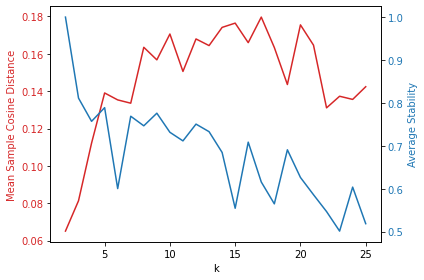

In [310]:
mean_cosine_distances = []
average_stabilities = []

for j in range(2,26):
    nmf = NMF(n_components=j, init='random', random_state=0, max_iter=10000)  # you can change n_components based on your needs
    df_nmf = nmf.fit_transform(mut_encoded_matrix)
    kmeans = KMeans(n_clusters= j, random_state=0, max_iter=10000)
    kmeans.fit(df_nmf)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    cosine_dists = []
    for cluster in range(j):
        cluster_points = df_nmf[labels == cluster]
        cluster_center = centers[cluster]
        cosine_dists.extend(cosine_distances(cluster_points, cluster_center.reshape(1, -1)).flatten())
    mean_cosine_distances.append(np.mean(cosine_dists))
    stabilities = []
    for _ in range(100):  # Perform bootstrapping 100 times
        # Create a bootstrap sample
        lambda_x = 1
        bootstrap_sample = np.random.poisson(df_nmf * lambda_x)
        # Perform k-means clustering on the bootstrap sample
        bootstrap_kmeans = KMeans(n_clusters= j, random_state=0).fit(bootstrap_sample)
        # Compute stability as the adjusted rand index between the bootstrap clustering and the original clustering
        stability = adjusted_rand_score(labels, bootstrap_kmeans.predict(df_nmf))
        stabilities.append(stability)
    average_stabilities.append(np.mean(stabilities))
    
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('Mean Sample Cosine Distance', color=color)
ax1.plot(range(2, 26), mean_cosine_distances, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Stability', color=color)
ax2.plot(range(2, 26), average_stabilities, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

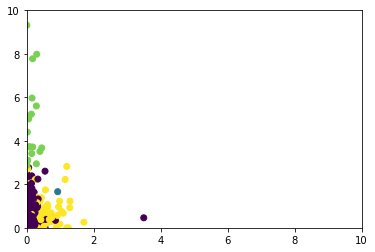

In [309]:
nmf = NMF(n_components=6, init='nndsvd', random_state=0, max_iter=10000)  # you can change n_components based on your needs
df_nmf = nmf.fit_transform(mut_encoded_matrix)
kmeans = KMeans(n_clusters= 6, random_state=0, max_iter=10000)
kmeans.fit(df_nmf)
y_pred = kmeans.predict(df_nmf)
SSE.append(kmeans.inertia_)
y_preds.append(y_pred)

labels = kmeans.labels_

# plot the data points, colored by their assigned cluster
plt.scatter(df_nmf[:, 0], df_nmf[:, 1], c=labels, cmap='viridis')
plt.xlim(0, 2)
plt.ylim(0,10)
plt.show()

In [249]:
for i in range(10):
    lambda_x = 1
    pd = np.random.poisson(mut_encoded_matrix * lambda_x)

NameError: name 'dims' is not defined

In [216]:
df_resampled

Mut,A(C>A)A,A(C>A)C,A(C>A)G,A(C>A)T,A(C>G)A,A(C>G)C,A(C>G)G,A(C>G)T,A(C>T)A,A(C>T)C,...,T(T>A)G,T(T>A)T,T(T>C)A,T(T>C)C,T(T>C)G,T(T>C)T,T(T>G)A,T(T>G)C,T(T>G)G,T(T>G)T
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-UF-A7JD,1,1,4,2,0,0,0,0,2,2,...,0,0,1,1,1,2,1,1,0,0


In [87]:
column_sums = np.sum(coefficient, axis=0)

# Index of the original feature most influenced by the hidden features
most_influenced_feature = np.argmax(column_sums)
most_influenced_feature

72

In [88]:
mut_matrix.iloc[72]

Mut    G(T>C)C
Name: (TCGA-4P-AA8J, KDM1A), dtype: object

In [ ]:
df_resampled

In [97]:
from SigProfilerExtractor import sigpro as sig
path_to_example_table = sig.importdata("matrix")
data = path_to_example_table 

ModuleNotFoundError: No module named 'SigProfilerExtractor'